In [1]:
import numpy as np
from matplotlib import pyplot as plt
import qcodes as qc
import scipy as sc
from scipy.fftpack import fft, rfft

In [3]:
#Load instruments using new init file
from v0_utils.InitFridge import QT5_init
station = QT5_init(DMM1=True, DMM2=False, DMM3=False, lockin1=True, lockin2=False, mdac=True, yokogawa=False, SGS1=False, 
                   SGS2=False, scope=True, rigol=True, awg_5208=False, magnet=False, alazar=False)

Connected to: Keysight Technologies 34465A (serial:MY57505814, firmware:A.02.17-02.40-02.17-00.52-04-01) in 0.84s
Connected to: Stanford_Research_Systems SR860 (serial:003231, firmware:v1.51) in 0.10s


C:\ProgramData\Anaconda3\envs\qcodes\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040037003E, firmware:1.4) in 10.19s
Connected to: KEYSIGHT TECHNOLOGIES MSOS254A (serial:MY58150108, firmware:06.20.00620) in 0.05s
Connected to: Rigol Technologies DG1062Z (serial:DG1ZA195206768, firmware:03.01.12) in 0.05s


c:\users\administrator\onedrive\bf5\code\qcodes\qcodes\instrument\parameter.py:247: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
Snapshot: Could not update parameter: period on rigol_burst
Snapshot: Could not update parameter: period on rigol_burst


## Measure current noise spectrum with SRS SR760 FFT spectrum analyzer

In [2]:
import visa
from importlib import reload
import time

In [3]:
rm = visa.ResourceManager()
sr760 = rm.open_resource('GPIB0::10::INSTR')

In [4]:
sr760.timeout = 30000

In [115]:
t0 = time.time()
sr760.write(r"SPAN 15\n")
sr760.write(r"MEAS 1,0\n") #Measure trace 1, type 0 = spectrum
sr760.write(r"DISP 1,0\n") #Trace 1, type 0 = log magnitude
sr760.write(r"UNIT 1,1\n") #Trace 1, type 1 = Vrms
sr760.write(r"VOEU 1,0\n") #Trace 1, type 1 -> units V
sr760.write(r"STRF 0\n") #start frequency

fvals = []
for i in range(400):
    fvals.append(float(sr760.query(r"BVAL? 1,{:d}\n".format(i).strip()))) #query the frequency value of the bins
fvals = np.array(fvals)

# sr760.write(r"AVGO 1\n") #Turn on averaging
# sr760.write(r"NAVG 20\n")

print('Duration = ', time.time()-t0)

Duration =  7.017630338668823


In [116]:
t0 = time.time()
sr760.write(r"ARNG 1\n") #Turn on auto range
#sr760.write(r"GET \n") #Start acquisition
#time.sleep(5)
data = sr760.query(r"SPEC? 1\n").strip() #query spectrum values from trace 1
data = np.array([float(d) for d in data.split(',')[:-1]])

print('Duration = ', time.time()-t0)

Duration =  4.098620891571045


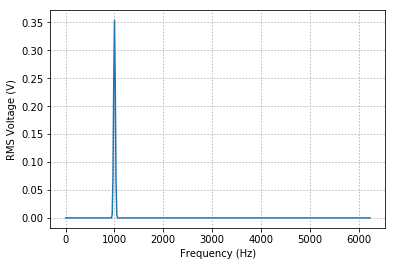

In [118]:
fig, ax = plt.subplots(1,1)
ax.plot(fvals, data)
#ax.set_ylim([0,500])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('RMS Voltage (V)')
ax.grid(dashes=[2,2])

In [119]:
1/(2*np.sqrt(2))

0.35355339059327373

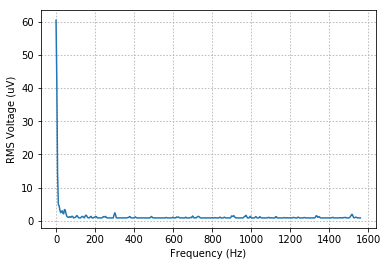

In [109]:
fig, ax = plt.subplots(1,1)
ax.plot(fvals, data * 1e6)
#ax.set_ylim([0,500])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('RMS Voltage (uV)')
ax.grid(dashes=[2,2])

In [116]:
sr760.write(r"OUTP 1")
for i in range(1000):
    sr760.write(r"STRT\n")

In [124]:
sr760.write(r"STRT\n")

(8, <StatusCode.success: 0>)

In [146]:
sr760.write(r"LOCL 0\n")

(10, <StatusCode.success: 0>)

In [137]:
sr760.write(r"SPAN 5\n")

(10, <StatusCode.success: 0>)

In [7]:
sr760.write(r"*CLS\n")

(8, <StatusCode.success: 0>)

## Collect time trace with scope

In [77]:
for i in range(4):
    station.scope.channels[i].display(False)
station.scope.ch1.display(True)
station.scope.timebase_range(10e-3)
station.scope.timebase_position(5e-3)
station.scope.ch1.range(2)

In [78]:
station.scope.trigger_enabled(True)
station.scope.trigger_edge_source('CHANnel1')
station.scope.trigger_edge_slope('positive')
station.scope.ch2.trigger_level(0.)

In [245]:
nPoints = 200000;
sample_rate = 10e6
time_range = nPoints/sample_rate
time_offset = time_range/2

station.scope.timebase_range(time_range)
station.scope.timebase_position(time_offset)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

In [246]:
rms_amp = .3
freq = 1700
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

In [247]:
station.scope.ch1.trace.prepare_curvedata()

In [248]:
ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

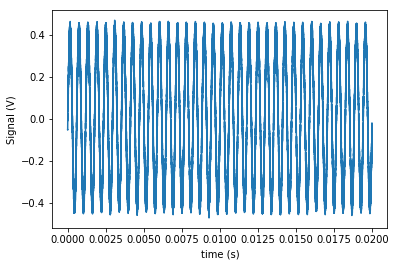

In [249]:
%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

In [250]:
spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

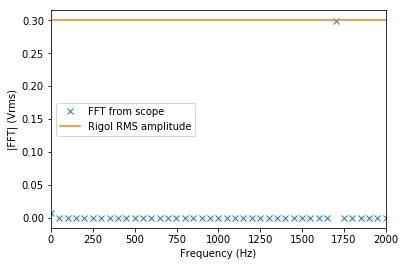

In [251]:
%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(-2000,2000,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 2e3])
plt.legend()
plt.show()

## Frequency dependence
Start going down in frequency to see that the scope can give meaningful data for small frequencies
Keep sample rate = 10x signal frequency, time record = 10/signal frequency

In [297]:
rms_amp = .3
freq = 2000
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

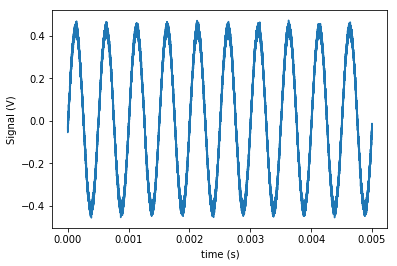

In [308]:
# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)
time_offset = time_range/2

station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

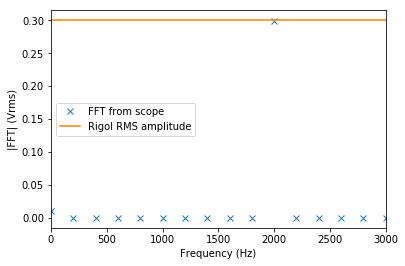

In [311]:
spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

### decrease to 200Hz

In [312]:
rms_amp = .3
freq = 200
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

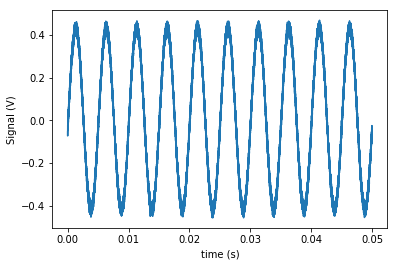

In [314]:
# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)
time_offset = time_range/2

station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

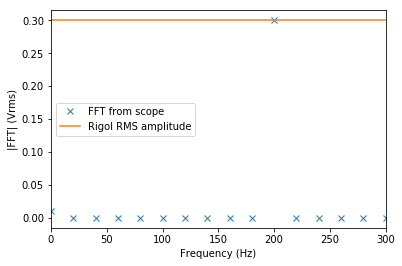

In [315]:
spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

### Decrease to 20Hz

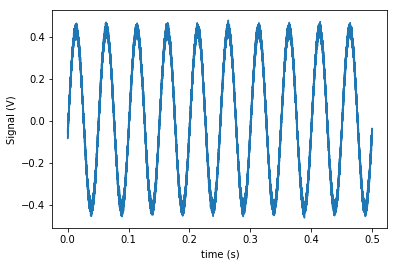

In [317]:
rms_amp = .3
freq = 20
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)
time_offset = time_range/2

station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

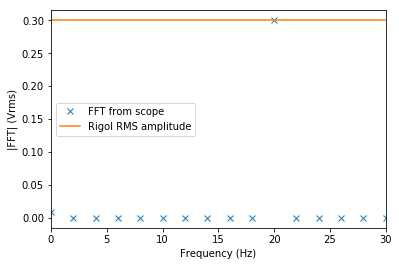

In [318]:
spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

### Decrease to 2 Hz

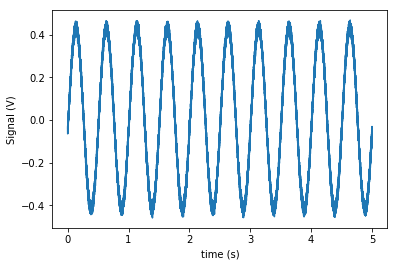

In [320]:
rms_amp = .3
freq = 2
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)
time_offset = time_range/2

station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

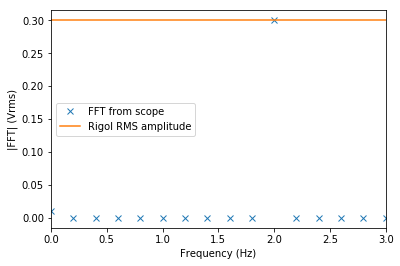

In [321]:
spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

## Decrease to 0.2Hz

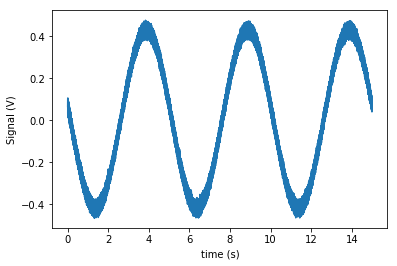

In [358]:
rms_amp = .3
freq = .2
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)


if time_range > 20:
    nPoints = 1500000
    sample_rate = 100000
    time_range = nPoints/sample_rate

time_offset = time_range/2    
    
station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

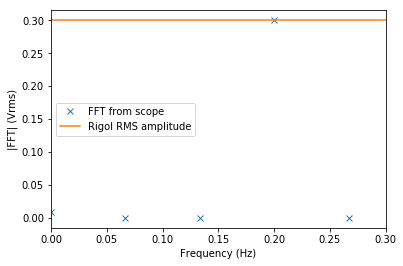

In [359]:
spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

### Try increasing nPoints to get finer frequency resolution

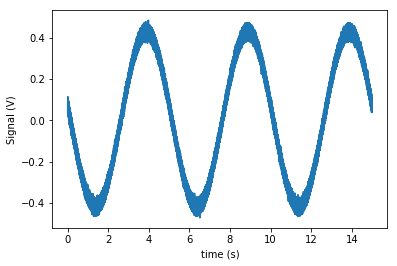

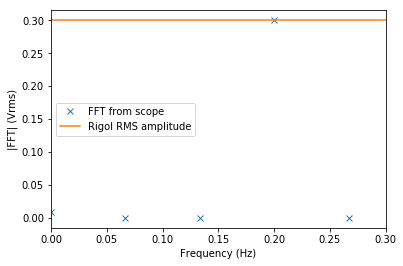

Frequency resolution:  0.0666666444444


In [362]:
rms_amp = .3
freq = .2
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)


if time_range > 20:
    nPoints = 3000000
    sample_rate = 200000
    time_range = nPoints/sample_rate

time_offset = time_range/2    
    
station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

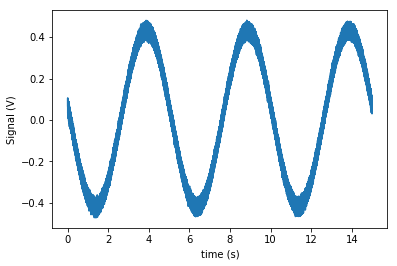

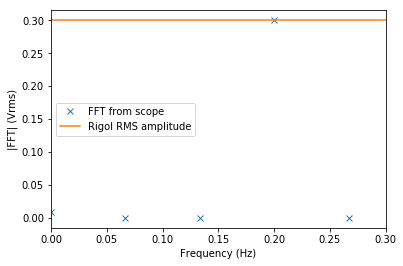

Frequency resolution:  0.0666666555556


In [364]:
rms_amp = .3
freq = .2
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)


if time_range > 20:
    nPoints = 6000000
    sample_rate = 400000
    time_range = nPoints/sample_rate

time_offset = time_range/2    
    
station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

This is of course a good reminder that it is the length of the record in time, not the number of points that sets the frequency resolution...

## Try increasing the time record to its max allowed value (20s)

In [368]:
station.scope.timeout(50)

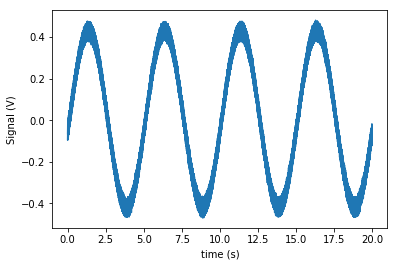

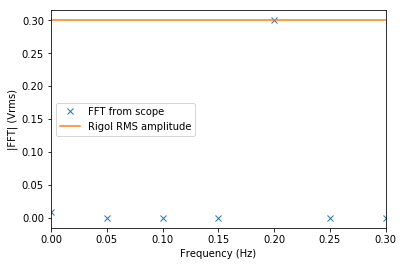

Frequency resolution:  0.04999999375


In [369]:
rms_amp = .3
freq = .2
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)


if time_range > 20:
    nPoints = 8000000
    sample_rate = 400000
    time_range = nPoints/sample_rate

time_offset = time_range/2    
    
station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.plot(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.plot(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

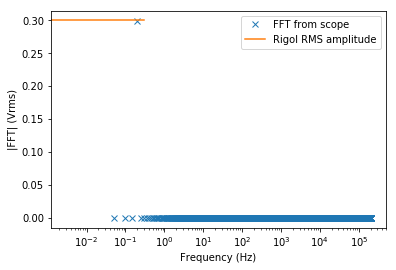

In [371]:
plt.semilogx(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.semilogx(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
#plt.xlim([0, 1.5*freq])
plt.legend()
plt.show()

## Make the sampling rate a bit lower to decrease memory requirements

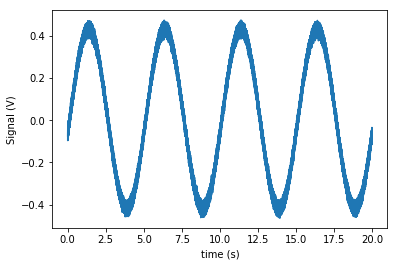

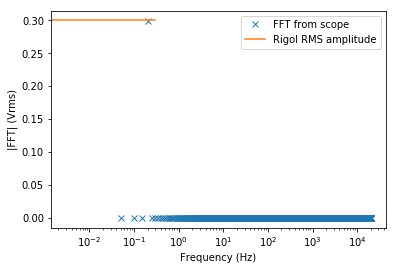

Frequency resolution:  0.0499999375


In [373]:
rms_amp = .3
freq = .2
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)


if time_range > 20:
    nPoints = 800000
    sample_rate = 40000
    time_range = nPoints/sample_rate

time_offset = time_range/2    
    
station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.semilogx(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.semilogx(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.legend()
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

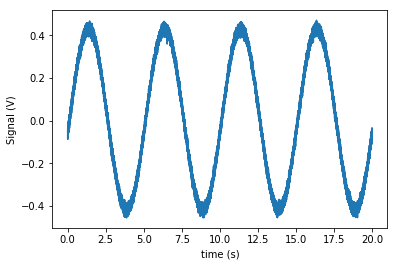

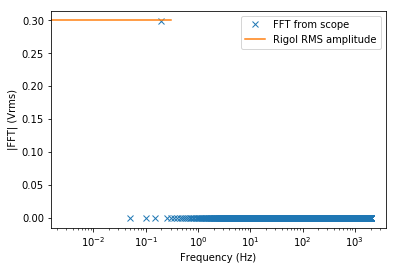

Frequency resolution:  0.049999375


In [375]:
rms_amp = .3
freq = .2
station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)


if time_range > 20:
    nPoints = 80000
    sample_rate = 4000
    time_range = nPoints/sample_rate

time_offset = time_range/2    
    
station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.semilogx(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
plt.semilogx(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.legend()
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

## FFTs with SR860 lockin

In [3]:
from importlib import reload
from pytopo.qctools import instruments as instools; reload(instools)
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
lockin1 = instools.create_inst(SR860, "lockin1", "USB0::0xB506::0x2000::003103::INSTR")


Connected to: Stanford_Research_Systems SR860 (serial:003103, firmware:v1.51) in 0.07s


In [7]:
f=400

station.rigol.ch2.impedance(50)
station.rigol.ch2.sin(freq=f, ampl=3, offset=0, phase=0)

In [19]:
capture_variable_name = "X"
lockin1.buffer[capture_variable_name]
lockin1.buffer.capture_config(capture_variable_name)
trigger_count = 400000
lockin1.buffer.set_capture_length_to_fit_samples(trigger_count)
lockin1.buffer.start_capture("ONE", "SAMP")
lockin1.buffer.wait_until_samples_captured(trigger_count)
lockin1.buffer.stop_capture()
data = lockin1.buffer.get_capture_data(trigger_count)
data = data['X']

In [21]:
len(data['X'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
ts = np.linspace(0,trigger_count/f, trigger_count)

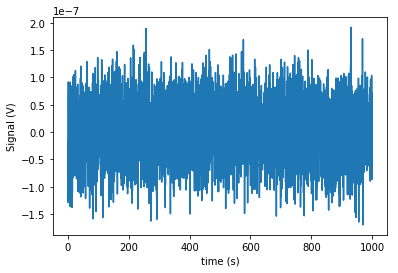

In [23]:
%matplotlib inline
plt.plot(ts, data)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

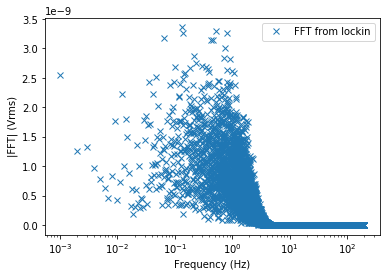

Frequency resolution:  0.0009999975


In [24]:
spectrum = abs(fft(data))
fs = sc.fftpack.fftfreq(data.size, ts[1]-ts[0])

%matplotlib inline
plt.semilogx(fs, 2*spectrum/(trigger_count*np.sqrt(2)), 'x', label='FFT from lockin')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.legend()
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

## Implement averaging of FFT's

In [5]:
import qcodes as qc
from qcodes import load_by_id
from qcodes import validators
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.database import initialise_database
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.utils.validators import Numbers

In [6]:
from importlib import reload

from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber
from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber

from pytopo.mplplots.init_nb_plotting import *

from pytopo.qctools.measurement import MeasurementExt
from pytopo.qctools import instruments as instools; reload(instools)

qc.config['core']['db_location'] = r"C:/Users/Administrator/OneDrive/BF5/Data/experiments.db"
initialise_database()

In [7]:
from v0_utils.qcodes_tools import \
    instrument_factory, init_or_create_database, load_or_create_experiment, \
    add_parameter_to_instrument, \
    DelegateParameter, VirtualInstrument

In [18]:
import time

In [56]:
#Setup Keysight MSOS254A scope for taking time traces for FFTs of source-drain current
def setup_scope_FFT(scope):
    for i in range(4):
        scope.channels[i].display(False)
    scope.ch1.display(True)
    scope.ch1.range(2)
    
    scope.trigger_enabled(True)
    scope.trigger_edge_source('CHANnel1')
    scope.trigger_edge_slope('positive')
    scope.ch1.trigger_level(0.)

    nPoints = 80000
    sample_rate = 4000
    time_range = nPoints/sample_rate

    time_offset = time_range/2    

    scope.timebase_range(time_range)
    scope.timebase_position(0)
    scope.acquire_points(nPoints)
    scope.acquire_sample_rate(sample_rate)

    scope.ch1.trace.prepare_curvedata()
    
    scope.timeout(50)
    
    return nPoints
    
#Virtual instrument to take FFTs from different instruments using qcodes 
#parameters so they can be saved with standard methods
class Noise_spec(Instrument):
    
    def __init__(self, name, scope, **kw):
        super().__init__(name, **kw)
        
        self.scope = scope        
        
        self.nPoints = setup_scope_FFT(self.scope)
        
        self.sample_rate = scope.acquire_sample_rate()
        
        #self.scope_FFT_freqs = np.empty(self.nPoints(), dtype=float)
    
        self.add_parameter('Scope_FFT', get_cmd=self._get_scope_FFT, set_cmd=None)
        
        self.add_parameter('Scope_average_idx', get_cmd=None, set_cmd=None, initial_value=1)
        
        self.add_parameter('Scope_FFT_freqs', get_cmd=self._get_scope_FFT_freqs, set_cmd=None)

    
    def _get_scope_FFT(self):
#         ts = np.linspace(0, self.nPoints()/self.scope.acquire_sample_rate(), self.nPoints())
        data = self.scope.ch1.trace()

        spectrum = abs(fft(data))
#         fs = sc.fftpack.fftfreq(data.size, ts[1]-ts[0])
        return spectrum
    
    def _get_scope_FFT_freqs(self):
        fs = sc.fftpack.fftfreq(self.nPoints, 1/self.sample_rate)
        return fs

In [43]:
sc.fftpack.fftfreq?

In [21]:
t0 = time.time()
nPoints = setup_scope_FFT(station.scope)
print('Time = ', time.time()-t0)

Time =  0.2200148105621338


In [24]:
t0 = time.time()
fs, spectrum = scope_FFT(station.scope, nPoints)
print('Time = ', time.time()-t0)

Time =  29.71029281616211


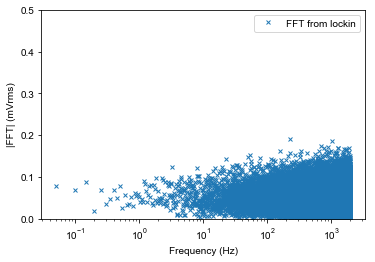

Frequency resolution:  0.049999375


In [27]:
%matplotlib inline
plt.semilogx(fs, 1000*2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from lockin')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

In [33]:
scope_fft = VirtualInstrument("scope_fft")

In [ ]:
# Define parameters
f_param = DelegateParameter(
    'f', 
    fast_ramp.values_with_repetitions_vector, 
    label='Frequency', 
    unit='Hz'
)
add_parameter_to_instrument(v_g_param, transistor_characterizer)

In [57]:
noise_spec = create_inst(Noise_spec, 'noise_spec', scope=station.scope, force_new_instance=True)


Instrument noise_spec already exists.


In [58]:
spectrum = noise_spec.Scope_FFT()
fs = noise_spec.Scope_FFT_freqs()

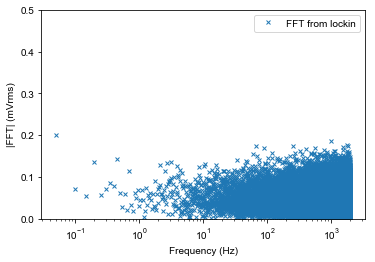

Frequency resolution:  0.05


In [59]:
%matplotlib inline
plt.semilogx(fs, 1000*2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from lockin')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

In [60]:
noise_spec.Scope_average_idx()

1

In [61]:
#Start user settings
idxvals = np.linspace(1, 2, 2)
#End user settings

exp = select_experiment('Code_testing', 'Open_circuit')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(noise_spec.Scope_average_idx)
meas.register_parameter(noise_spec.Scope_FFT_freqs)
meas.register_parameter(noise_spec.Scope_FFT, setpoints=[noise_spec.Scope_average_idx, noise_spec.Scope_FFT_freqs ])



with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for idx in idxvals:
        noise_spec.Scope_average_idx(idx)
        datasaver.add_result((noise_spec.Scope_average_idx, idx), 
                             (noise_spec.Scope_FFT_freqs, noise_spec.Scope_FFT_freqs()),
                             (noise_spec.Scope_FFT, noise_spec.Scope_FFT()))                             

Starting experimental run with id: 46


In [63]:
dv = qc.load_by_id(46)
dv

results #46@C:/Users/Administrator/OneDrive/BF5/Data/experiments.db
-------------------------------------------------------------------
noise_spec_Scope_average_idx - numeric
noise_spec_Scope_FFT_freqs - numeric
noise_spec_Scope_FFT - numeric

In [71]:
fs = np.array(dv.get_data("noise_spec_Scope_FFT_freqs"))[:,0] 
idx = np.array(dv.get_data("noise_spec_Scope_average_idx"))[:,0] 
spectrum = np.array(dv.get_data("noise_spec_Scope_FFT"))[:,0] 


In [74]:
fs = np.unique(fs)
idx = np.unique(idx)
spectrum = spectrum.reshape(idx.size, fs.size)

In [78]:
average = np.empty(len(fs))
for i in range(len(idx)):
    average += spectrum[i,:]
average = average/len(idx)

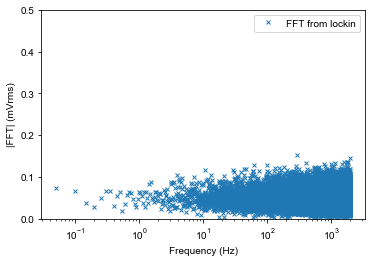

Frequency resolution:  0.049999999999954525


In [109]:
%matplotlib inline
nPoints = noise_spec.nPoints
plt.semilogx(fs, 1000*2*average/(nPoints*np.sqrt(2)), 'x', label='FFT from lockin')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

In [110]:
#Start user settings
idxvals = np.linspace(1, 10, 10)
#End user settings

exp = select_experiment('Code_testing', 'Open_circuit')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(noise_spec.Scope_average_idx)
meas.register_parameter(noise_spec.Scope_FFT_freqs)
meas.register_parameter(noise_spec.Scope_FFT, setpoints=[noise_spec.Scope_average_idx, noise_spec.Scope_FFT_freqs ])



with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for idx in idxvals:
        noise_spec.Scope_average_idx(idx)
        datasaver.add_result((noise_spec.Scope_average_idx, idx), 
                             (noise_spec.Scope_FFT_freqs, noise_spec.Scope_FFT_freqs()),
                             (noise_spec.Scope_FFT, noise_spec.Scope_FFT()))                             

Starting experimental run with id: 47


In [111]:
dv = qc.load_by_id(47)
dv

results #47@C:/Users/Administrator/OneDrive/BF5/Data/experiments.db
-------------------------------------------------------------------
noise_spec_Scope_average_idx - numeric
noise_spec_Scope_FFT_freqs - numeric
noise_spec_Scope_FFT - numeric

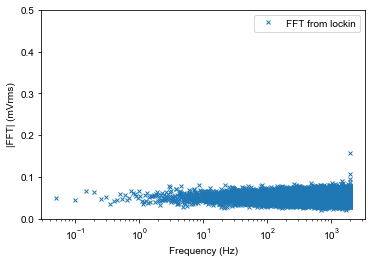

Frequency resolution:  0.049999999999954525


In [112]:
fs = np.array(dv.get_data("noise_spec_Scope_FFT_freqs"))[:,0] 
idx = np.array(dv.get_data("noise_spec_Scope_average_idx"))[:,0] 
spectrum = np.array(dv.get_data("noise_spec_Scope_FFT"))[:,0] 

fs = np.unique(fs)
idx = np.unique(idx)
spectrum = spectrum.reshape(idx.size, fs.size)

average = np.empty(len(fs))
for i in range(len(idx)):
    average += spectrum[i,:]
average = average/len(idx)

nPoints = noise_spec.nPoints
plt.semilogx(fs, 1000*2*average/(nPoints*np.sqrt(2)), 'x', label='FFT from lockin')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

In [113]:
#Start user settings
idxvals = np.linspace(1, 50, 50)
#End user settings

exp = select_experiment('Code_testing', 'Open_circuit')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(noise_spec.Scope_average_idx)
meas.register_parameter(noise_spec.Scope_FFT_freqs)
meas.register_parameter(noise_spec.Scope_FFT, setpoints=[noise_spec.Scope_average_idx, noise_spec.Scope_FFT_freqs ])



with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for idx in idxvals:
        noise_spec.Scope_average_idx(idx)
        datasaver.add_result((noise_spec.Scope_average_idx, idx), 
                             (noise_spec.Scope_FFT_freqs, noise_spec.Scope_FFT_freqs()),
                             (noise_spec.Scope_FFT, noise_spec.Scope_FFT()))       

Starting experimental run with id: 48


In [114]:
dv = qc.load_by_id(48)
dv

results #48@C:/Users/Administrator/OneDrive/BF5/Data/experiments.db
-------------------------------------------------------------------
noise_spec_Scope_average_idx - numeric
noise_spec_Scope_FFT_freqs - numeric
noise_spec_Scope_FFT - numeric

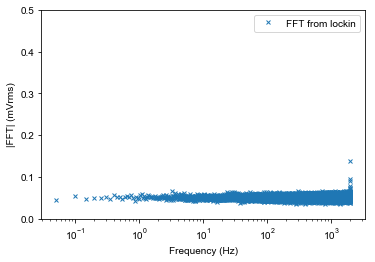

Frequency resolution:  0.049999999999954525


In [115]:
fs = np.array(dv.get_data("noise_spec_Scope_FFT_freqs"))[:,0] 
idx = np.array(dv.get_data("noise_spec_Scope_average_idx"))[:,0] 
spectrum = np.array(dv.get_data("noise_spec_Scope_FFT"))[:,0] 

fs = np.unique(fs)
idx = np.unique(idx)
spectrum = spectrum.reshape(idx.size, fs.size)

average = np.empty(len(fs))
for i in range(len(idx)):
    average += spectrum[i,:]
average = average/len(idx)

nPoints = noise_spec.nPoints
plt.semilogx(fs, 1000*2*average/(nPoints*np.sqrt(2)), 'x', label='FFT from lockin')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

## With device connected
Bias = 0, gate = 0

In [116]:
#Start user settings
idxvals = np.linspace(1, 10, 10)
#End user settings

exp = select_experiment('Code_testing', 'Open_circuit')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(noise_spec.Scope_average_idx)
meas.register_parameter(noise_spec.Scope_FFT_freqs)
meas.register_parameter(noise_spec.Scope_FFT, setpoints=[noise_spec.Scope_average_idx, noise_spec.Scope_FFT_freqs ])



with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for idx in idxvals:
        noise_spec.Scope_average_idx(idx)
        datasaver.add_result((noise_spec.Scope_average_idx, idx), 
                             (noise_spec.Scope_FFT_freqs, noise_spec.Scope_FFT_freqs()),
                             (noise_spec.Scope_FFT, noise_spec.Scope_FFT()))        

Starting experimental run with id: 49


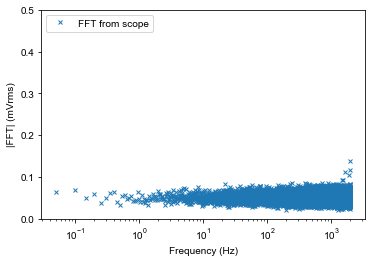

Frequency resolution:  0.049999999999954525


In [117]:
dv = qc.load_by_id(49)
fs = np.array(dv.get_data("noise_spec_Scope_FFT_freqs"))[:,0] 
idx = np.array(dv.get_data("noise_spec_Scope_average_idx"))[:,0] 
spectrum = np.array(dv.get_data("noise_spec_Scope_FFT"))[:,0] 

fs = np.unique(fs)
idx = np.unique(idx)
spectrum = spectrum.reshape(idx.size, fs.size)

average = np.empty(len(fs))
for i in range(len(idx)):
    average += spectrum[i,:]
average = average/len(idx)

nPoints = noise_spec.nPoints
plt.semilogx(fs, 1000*2*average/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])